In [3]:
import os
from dotenv import load_dotenv
from groq import Groq


# Load environment variables from .env file
load_dotenv()

def process_with_groq_clip(state):
    # Get API key from environment
    api_key = os.getenv("GROQ_API_KEY")
    
    # Debug: Check if API key is loaded
    if not api_key:
        print("❌ GROQ_API_KEY not found in environment variables")
        return {**state, "llm_response": "API key not configured"}
    
    print(f"✅ API key loaded: {api_key[:6]}...")

In [ ]:
from langgraph.graph import StateGraph, START, END
from typing import TypedDict, Dict, Any, List
import os
import markdown
import re
from PIL import Image
import base64
from groq import Groq
from pathlib import Path
import json

class QuestionState(TypedDict):
    folder_path: str
    documents: List[Dict[str, Any]]
    image_paths: List[str]
    question: str
    user_answer: str
    feedback: str
    scores: List[float]
    current_question_index: int
    total_questions: int
    average_score: float
    grade: str
    recommendation: str

def extract_image_paths(md_text: str, folder_path: str) -> List[str]:
    img_pattern = r'!\[.*?\]\((.*?)\)'
    relative_paths = re.findall(img_pattern, md_text)
    absolute_paths = []
    
    for img_path in relative_paths:
        if not os.path.isabs(img_path):
            abs_path = os.path.join(folder_path, img_path)
            if os.path.exists(abs_path):
                absolute_paths.append(abs_path)
        else:
            if os.path.exists(img_path):
                absolute_paths.append(img_path)
    
    return absolute_paths

def encode_image_to_base64(image_path: str) -> str:
    """Convert image to base64 for Groq API"""
    try:
        with open(image_path, "rb") as image_file:
            encoded_string = base64.b64encode(image_file.read()).decode('utf-8')
        
        image_format = os.path.splitext(image_path)[1][1:].lower()
        if image_format == 'jpg':
            image_format = 'jpeg'
        
        return f"data:image/{image_format};base64,{encoded_string}"
    except Exception as e:
        print(f"❌ Error encoding image {image_path}: {str(e)}")
        return None

# Node 1: Setup session - choose number of questions
def setup_session(state: QuestionState) -> QuestionState:
    print("\n🃏 Flashcard Q&A Session Setup")
    print("═" * 40)
    print("Choose your session length:")
    print("1. Quick Session (3 questions)")
    print("2. Standard Session (6 questions)")
    print("3. Extended Session (10 questions)")
    
    while True:
        choice = input("\nEnter choice (1/2/3): ").strip()
        if choice == "1":
            total_questions = 3
            break
        elif choice == "2":
            total_questions = 6
            break
        elif choice == "3":
            total_questions = 10
            break
        else:
            print("Please enter 1, 2, or 3")
    
    print(f"✅ Session configured for {total_questions} questions")
    
    return {
        **state,
        "total_questions": total_questions,
        "current_question_index": 0,
        "scores": []
    }

# Node 2: Load documents and images
def load_content(state: QuestionState) -> QuestionState:
    folder_path = state["folder_path"]
    
    if not os.path.isdir(folder_path):
        raise ValueError(f"Invalid folder path: {folder_path}")
    
    documents = []
    all_image_paths = []
    
    print(f"📁 Loading content from: {folder_path}")
    
    # Load markdown files
    md_files = list(Path(folder_path).glob("*.md"))
    for file_path in md_files:
        with open(file_path, 'r', encoding='utf-8') as f:
            md_content = f.read()
        
        image_paths = extract_image_paths(md_content, folder_path)
        all_image_paths.extend(image_paths)
        
        documents.append({
            "filename": file_path.name,
            "markdown": md_content,
            "word_count": len(md_content.split())
        })
    
    # Find ALL images in folder
    image_extensions = {'.jpg', '.jpeg', '.png', '.gif', '.bmp', '.webp'}
    for file_path in Path(folder_path).rglob("*"):
        if file_path.suffix.lower() in image_extensions:
            abs_path = str(file_path.absolute())
            if abs_path not in all_image_paths:
                all_image_paths.append(abs_path)
    
    print(f"✅ Found {len(documents)} documents and {len(all_image_paths)} images")
    
    return {
        **state,
        "documents": documents,
        "image_paths": all_image_paths
    }

# Node 3: Generate flashcard question
def generate_flashcard_question(state: QuestionState) -> QuestionState:
    documents = state["documents"]
    image_paths = state["image_paths"]
    current_index = state.get("current_question_index", 0) + 1
    
    # Update current question index
    updated_state = {**state, "current_question_index": current_index}
    
    has_text = len(documents) > 0
    has_images = len(image_paths) > 0
    
    if not has_text and not has_images:
        question = "❌ No content found. Please add markdown files or images to the folder."
        return {**updated_state, "question": question}
    
    # Prepare multimodal content for Groq API
    content = []
    
    # Add text content if available
    if has_text:
        combined_text = "\n\n".join([doc["markdown"] for doc in documents])
        content.append({
            "type": "text",
            "text": f"Text Content:\n{combined_text[:2000]}"  # Limit text length
        })
    
    # Add images if available (limit to first 3 images)
    if has_images:
        print(f"🖼️ Processing {min(len(image_paths), 3)} images for question generation...")
        
        for img_path in image_paths[:3]:
            base64_image = encode_image_to_base64(img_path)
            if base64_image:
                content.append({
                    "type": "image_url",
                    "image_url": {
                        "url": base64_image
                    }
                })
                print(f"✅ Added {os.path.basename(img_path)}")
    
    # **MANDATORY INSTRUCTION FOR QUESTION GENERATION** (DO NOT REMOVE)
    if has_text and has_images:
        instruction = "Based on the text content and images provided above, generate ONE thoughtful question that tests understanding of the key concepts. The question should integrate both textual and visual information where relevant."
    elif has_text:
        instruction = "Based on the text content above, generate ONE thoughtful question that tests understanding of the key concepts."
    else:
        instruction = "Based on the images provided above, generate ONE thoughtful question that tests understanding of the visual content and concepts shown."
    
    content.append({
        "type": "text",
        "text": f"This is question {current_index} of {state['total_questions']}. {instruction}"
    })
    
    try:
        client = Groq(api_key=os.getenv("GROQ_API_KEY"))
        
        response = client.chat.completions.create(
            messages=[{
                "role": "user",
                "content": content
            }],
            model="meta-llama/llama-4-scout-17b-16e-instruct",
            max_tokens=200,
            temperature=0.7
        )
        
        question = response.choices[0].message.content.strip()
        
        # Format the question with question number
        formatted_question = f"📚 **Question {current_index}/{state['total_questions']} - Flashcard:**\n\n{question}"
        
        print(f"\n🤔 FLASHCARD QUESTION GENERATED:")
        print(f"─" * 50)
        print(formatted_question)
        print(f"─" * 50)
        
    except Exception as e:
        print(f"⚠️ Error generating question: {str(e)}")
        formatted_question = f"❌ Could not generate question due to API error: {str(e)}"
    
    return {**updated_state, "question": formatted_question}



# Node 4: Collect user answer
def collect_answer(state: QuestionState) -> QuestionState:
    print(f"\nYour turn! Please answer the flashcard question above:")
    user_answer = input("Your answer: ").strip()
    
    if not user_answer:
        user_answer = "No answer provided."
    
    print(f"\n✅ Answer recorded: {len(user_answer)} characters")
    
    return {**state, "user_answer": user_answer}

# Node 5: Provide feedback using Groq's multimodal API (UNCHANGED)
def provide_multimodal_feedback(state: QuestionState) -> QuestionState:
    question = state["question"]
    user_answer = state["user_answer"]
    documents = state["documents"]
    image_paths = state["image_paths"]
    
    # Build content as a list for multimodal input
    content = []
    
    feedback_text = f"""
    Question: {question}
    
    User's Answer: {user_answer}
    
    Please provide brief, constructive feedback on the user's answer based on the question and available content (text and/or images). Be encouraging but honest about accuracy and completeness.
    """
    
    content.append({
        "type": "text",
        "text": feedback_text
    })
    
    # Add text context if available
    if documents:
        text_context = "\n".join([doc["markdown"][:500] for doc in documents])
        content.append({
            "type": "text", 
            "text": f"Original Text Context:\n{text_context}"
        })
    
    # Add images for context (limit to 3 for feedback)
    if image_paths:
        print(f"🖼️ Including {min(len(image_paths), 3)} images in feedback context...")
        
        for img_path in image_paths[:3]:
            base64_image = encode_image_to_base64(img_path)
            if base64_image:
                content.append({
                    "type": "image_url",
                    "image_url": {
                        "url": base64_image
                    }
                })
    
    try:
        client = Groq(api_key=os.getenv("GROQ_API_KEY"))
        
        response = client.chat.completions.create(
            messages=[{
                "role": "user", 
                "content": content
            }],
            model="meta-llama/llama-4-scout-17b-16e-instruct",
            max_tokens=300,
            temperature=0.5
        )
        
        feedback = response.choices[0].message.content.strip()
        
    except Exception as e:
        content_summary = f"{len(documents)} documents and {len(image_paths)} images"
        feedback = f"Thank you for your answer! Based on the analysis of {content_summary}, your response has been recorded. Due to a technical issue ({str(e)}), detailed feedback is not available right now."
    
    print(f"\n💭 MULTIMODAL FEEDBACK:")
    print(f"─" * 50)
    print(feedback)
    print(f"─" * 50)
    
    return {**state, "feedback": feedback}

# **NEW Node 6: LLM-based answer evaluation with your specified weights**
def evaluate_answer(state: QuestionState) -> QuestionState:
    question = state["question"]
    user_answer = state["user_answer"]
    documents = state["documents"]
    image_paths = state["image_paths"]
    
    # Build content as a list for multimodal input
    content = []
    
    # Add the question and user's answer as text
    evaluation_text = f"""
You are an expert evaluator. Please evaluate the user's answer and provide scores based on these exact criteria:

1. Content Correctness (70% weight): How accurate and complete is the answer based on the source material?
2. Fluency & Coherence (10% weight): Grammar, logical flow, clear structure, no contradictions
3. Confidence & Clarity (10% weight): Clear expression, minimal hesitation markers, appropriate length
4. Relevance (10% weight): How directly the answer addresses the specific flashcard question

Question: {question}

User's Answer: {user_answer}

Please return ONLY a valid JSON object with this exact format (no additional text):
{{
    "content_correctness": score_0_to_100,
    "fluency_coherence": score_0_to_100,
    "confidence_clarity": score_0_to_100,
    "relevance": score_0_to_100,
    "total_score": weighted_average_score_0_to_100
}}

Calculate total_score as: (content_correctness * 0.70) + (fluency_coherence * 0.10) + (confidence_clarity * 0.10) + (relevance * 0.10)

Source Material for Reference:
"""
    
    content.append({
        "type": "text",
        "text": evaluation_text
    })
    
    # Add text context if available
    if documents:
        text_context = "\n".join([doc["markdown"][:1000] for doc in documents])
        content.append({
            "type": "text", 
            "text": f"Text Context:\n{text_context}"
        })
    
    # Add images for context (limit to 3 for evaluation)
    if image_paths:
        for img_path in image_paths[:3]:
            base64_image = encode_image_to_base64(img_path)
            if base64_image:
                content.append({
                    "type": "image_url",
                    "image_url": {
                        "url": base64_image
                    }
                })
    
    try:
        client = Groq(api_key=os.getenv("GROQ_API_KEY"))
        
        response = client.chat.completions.create(
            messages=[{
                "role": "user", 
                "content": content
            }],
            model="                                             edddeghfkdjrjtgerthwieorthoierfhgehekrjfherherhfjjdfhuerewffff fdfdfdfdfdffdfdfdfdfdfdfdf",
            max_tokens=200,
            temperature=0
        )
        
        output = response.choices[0].message.content.strip()
        print(f"🔍 LLM Evaluation Response: {output}")
        
        # Extract JSON from response (let it fail if invalid)
        if '{' in output and '}' in output:
            json_start = output.find('{')
            json_end = output.rfind('}') + 1
            json_str = output[json_start:json_end]
            scores_dict = json.loads(json_str)
            weighted_score = float(scores_dict.get("total_score", 0))
        else:
            raise ValueError("No valid JSON found in LLM response")
            
    except Exception as e:
        print(f"❌ LLM Evaluation failed: {str(e)}")
        # Don't add any fallback score - let it be 0 or fail completely
        weighted_score = 0
    
    # Add score to list
    scores = state.get("scores", [])
    scores.append(weighted_score)
    
    print(f"\n🎯 SCORE for Question {state['current_question_index']}: {weighted_score:.1f}/100")
    
    return {**state, "scores": scores}



# Node 7: Session manager - decides whether to continue or end
def session_manager(state: QuestionState) -> str:
    current = state.get("current_question_index", 0)
    total = state.get("total_questions", 3)
    
    print(f"🔍 Session Check: Question {current}/{total} completed")
    
    if current < total:
        print(f"\n➡️ Proceeding to next question...")
        return "generate_flashcard_question"
    else:
        print(f"\n🏁 All {total} questions completed! Calculating final grade...")
        return "calculate_final_grade"

# **NEW Node 8: Calculate final average and grade**
def calculate_final_grade(state: QuestionState) -> QuestionState:
    scores = state.get("scores", [])
    
    if not scores:
        avg = 0
    else:
        avg = sum(scores) / len(scores)
    
    # Grading rubric based on your specifications
    if avg >= 80:
        grade = "🟢 Pass"
        recommendation = "Excellent! You have strong understanding. Move to the next topic."
    elif avg >= 60:
        grade = "🟡 Needs Revision"  
        recommendation = "Partial understanding. Review the material and try 2-3 more questions."
    else:
        grade = "🔴 Retry Flashcards"
        recommendation = "Poor understanding. Restart with focused study of the material."
    
    print(f"\n" + "="*60)
    print(f"📊 FINAL SESSION RESULTS")
    print(f"="*60)
    print(f"Questions Answered: {len(scores)}")
    print(f"Individual Scores: {[f'{s:.1f}' for s in scores]}")
    print(f"Average Score: {avg:.2f}/100")
    print(f"Final Grade: {grade}")
    print(f"Recommendation: {recommendation}")
    print(f"="*60)
    
    return {
        **state, 
        "average_score": avg, 
        "grade": grade, 
        "recommendation": recommendation
    }

# Build the complete workflow
def create_flashcard_qa_workflow():
    workflow = StateGraph(QuestionState)
    
    # Add all nodes
    workflow.add_node("setup_session", setup_session)
    workflow.add_node("load_content", load_content)
    workflow.add_node("generate_flashcard_question", generate_flashcard_question)
    workflow.add_node("collect_answer", collect_answer)
    workflow.add_node("provide_feedback", provide_multimodal_feedback)
    workflow.add_node("evaluate_answer", evaluate_answer)
    workflow.add_node("calculate_final_grade", calculate_final_grade)
    
    # Define linear edges first
    workflow.set_entry_point("setup_session")
    workflow.add_edge("setup_session", "load_content")
    workflow.add_edge("load_content", "generate_flashcard_question")
    workflow.add_edge("generate_flashcard_question", "collect_answer")
    workflow.add_edge("collect_answer", "provide_feedback")
    workflow.add_edge("provide_feedback", "evaluate_answer")
    
    # Fixed conditional edge - only from evaluate_answer
    workflow.add_conditional_edges(
        "evaluate_answer",
        session_manager,
        {
            "generate_flashcard_question": "generate_flashcard_question",
            "calculate_final_grade": "calculate_final_grade"
        }
    )
    
    workflow.add_edge("calculate_final_grade", END)
    
    return workflow.compile()


# Main execution function
def run_flashcard_qa_session():
    print("🃏 Advanced Flashcard Q&A with AI Scoring")
    print("═" * 50)
    print("📋 Supports: Text + Images, Text only, or Images only")
    print("🤖 Uses Groq's multimodal AI for intelligent feedback & scoring")
    print("🎯 Weighted scoring: Content(70%) + Fluency(10%) + Clarity(10%) + Relevance(10%)")
    
    # Get folder path
    folder_path = input("\nEnter folder path with markdown files and/or images: ").strip()
    if not folder_path:
        folder_path = "."
    
    # Initialize state
    initial_state = QuestionState(
        folder_path=folder_path,
        documents=[],
        image_paths=[],
        question="",
        user_answer="",
        feedback="",
        scores=[],
        current_question_index=0,
        total_questions=3,
        average_score=0.0,
        grade="",
        recommendation=""
    )
    
    # Run workflow
    try:
        workflow = create_flashcard_qa_workflow()
        result = workflow.invoke(initial_state)
        
        print(f"\n🎉 SESSION SUMMARY:")
        print(f" • Content loaded: {len(result['documents'])} documents, {len(result['image_paths'])} images")
        print(f" • Questions completed: {len(result['scores'])}")
        print(f" • Final grade: {result['grade']}")
        print(f" • Average score: {result['average_score']:.2f}/100")
        
    except Exception as e:
        print(f"❌ Error: {str(e)}")
        print("Please check your folder path and Groq API key.")

In [8]:
if __name__ == "__main__":
    run_flashcard_qa_session()

🃏 Advanced Flashcard Q&A with AI Scoring
══════════════════════════════════════════════════
📋 Supports: Text + Images, Text only, or Images only
🤖 Uses Groq's multimodal AI for intelligent feedback & scoring
🎯 Weighted scoring: Content(70%) + Fluency(10%) + Clarity(10%) + Relevance(10%)

🃏 Flashcard Q&A Session Setup
════════════════════════════════════════
Choose your session length:
1. Quick Session (3 questions)
2. Standard Session (6 questions)
3. Extended Session (10 questions)
✅ Session configured for 3 questions
📁 Loading content from: E:\7. Projects From Sem 3\RAG\data\rag_8_Weight_Initilization_20250906_032237
✅ Found 1 documents and 4 images
🖼️ Processing 3 images for question generation...
✅ Added Pasted image 20250905201943.png
✅ Added Pasted image 20250905202330.png
✅ Added Pasted image 20250905201943.png

🤔 FLASHCARD QUESTION GENERATED:
──────────────────────────────────────────────────
📚 **Question 1/3 - Flashcard:**

## Question 1: Understanding Weight Initialization in

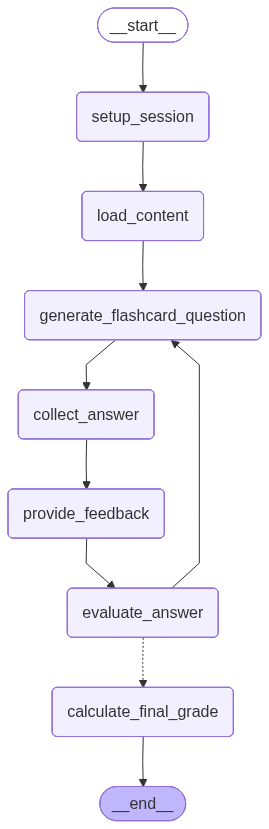

In [2]:
from IPython.display import Image, display

# Create workflow
workflow = create_flashcard_qa_workflow()

# Get graph object
graph = workflow.get_graph(xray=True)  # xray=True gives you full detail

# Render as PNG Mermaid diagram
png_data = graph.draw_mermaid_png()

# Show in notebook
display(Image(png_data))
